# **3 - Sentiment Analysis using pretrained multilingual BERT**

This notebook contains the code that implements sentiment analysis on the open-ended responses, engineers new features based on the results, and computes correlations within theme clusters to identify potential keywords associated with positive sentiment.

**Requirements**: This notebook requires having installed the packages declared in the `requirements.txt` file. Please make sure to have followed the instructions provided in the `README.md` file before running it.

In [1]:
from ml_utils import *
from utils import *

## **Sentiment Analysis Model set up**

In [2]:
# Reads survey_df
data_dir = 'data'
data_filename = 'coded_response_dataframe.pkl'
survey_df = read_file(data_dir, data_filename)

# Instantiates pretrained BERT model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)

## **Get relevant documents per theme**

In [3]:
# Loads LDA model's artifacts
X_filename = 'X.joblib'
vectorizer_filename = 'vectorizer.joblib'
model_filename = 'lda_model.joblib'
artifacts_dir = "artifacts/"

X = joblib.load(os.path.join("../" + artifacts_dir, X_filename))
vectorizer = joblib.load(os.path.join("../" + artifacts_dir, vectorizer_filename))
lda_model = joblib.load(os.path.join("../" + artifacts_dir, model_filename))

In [4]:
# Builds theme matrix
df_document_themes = create_theme_matrix(X, lda_model, survey_df)

# Gets relevant documents per theme cluster
theme_docs = {}
N_CLUSTERS = 5

for n in range(N_CLUSTERS):
    theme_docs[f"Theme #{n}"] = get_theme_documents(survey_df, df_document_themes, n)

## **Compute Sentiment Analysis**

In [5]:
# Computes sentiment analysis on all theme documents
sentiment_scores = {}
i = 0
for theme, docs in theme_docs.items():
    for doc in docs:
        sentiment_scores[f"{theme}_Doc{i}"] = classifier(doc)
        i += 1
    print(f"{theme} completed...")    
    i = 0  # resets index to start at 0 on each theme
        
print("Sentiment Analysis complete!")

Theme #0 completed...
Theme #1 completed...
Theme #2 completed...
Theme #3 completed...
Theme #4 completed...
Sentiment Analysis complete!


In [6]:
sentiment_scores['Theme #0_Doc0']

[[{'label': '1 star', 'score': 0.1870577037334442},
  {'label': '2 stars', 'score': 0.26336735486984253},
  {'label': '3 stars', 'score': 0.2919510006904602},
  {'label': '4 stars', 'score': 0.1650795042514801},
  {'label': '5 stars', 'score': 0.09254448115825653}]]

## **Detecting docs that are "high performers" within specific theme clusters**

In [7]:
# Selects documents which have over 0.75 score in Label 5 (most positive)
highest_performing_docs = {}
for doc_id, labels in sentiment_scores.items():
    curr_theme = doc_id.split("_")[0]
    if labels[0][4]["score"] > 0.75:  # high score threshold to reduce entropy in class probablities
        idx = int(doc_id.split("_")[1].strip("Doc"))
        doc = theme_docs[curr_theme][idx]
        if len(word_tokenize(doc)) > 5:  # filter docs with few words
            highest_performing_docs[doc_id] = doc

In [8]:
highest_performing_docs

{'Theme #0_Doc428': 'Pls search on ur a phone 📲 amp all the food 🥘 amp time are the most amazing 😉 I love 💕 amp your family and your life in this bitch was my favorite place in town food 🥘 I gotta eat good pizza 🍕 I gotta Yes ',
 'Theme #0_Doc522': 'Means every word true and I believe he genuinely means it , we need to control the virus ',
 'Theme #0_Doc581': 'He is aware of the suffering and humanity of the hurting and he wants to help! I love this message and how it addressed my deepest need/desires for government help!!!',
 'Theme #0_Doc620': 'I love this video and his statement, it goes to show you how positive he is to wish the First Lady and the president of the United States of America well wishes and speedy recovery.',
 'Theme #0_Doc724': 'He said the truth about this virus and wear the mask to help save others and yourself . I agree with him 100 % ..do your job people !',
 'Theme #0_Doc874': 'I think he is a great leader as well as great person',
 'Theme #0_Doc1033': 'he know 

## **Data visualization**

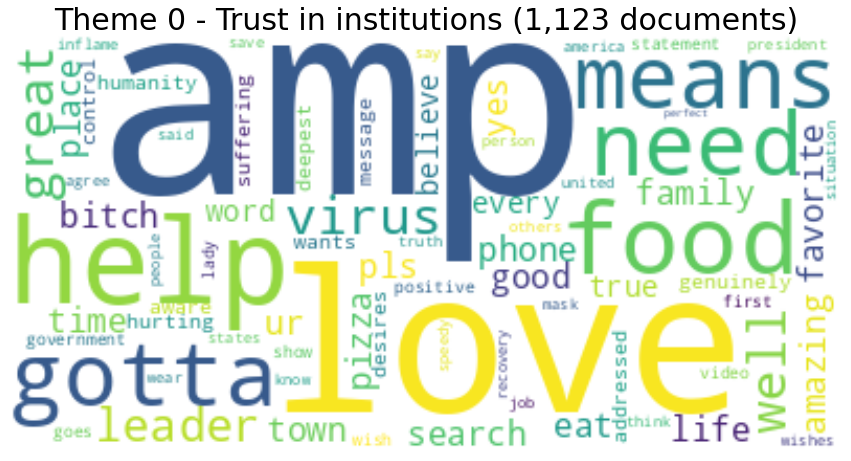

In [9]:
stopwords = set(STOPWORDS)
stopwords.update("to", "I", "Others", ":", "'", "''", "with", "to", "a", "for", "(", ")", "?", ",", ".", 
                 "RE", "u", "He", "'s", "n't", "`s", "amp", "ur", "Pls")
theme0_pos_msg = " ".join([doc.lower() for doc_id, doc in highest_performing_docs.items() if "Theme #0" in doc_id])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(theme0_pos_msg)
plt.figure(figsize=[15, 8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Theme 0 - Trust in institutions (1,123 documents)", fontsize=30, pad=2)
plt.show()

**Related theme (True counts):**
* *Taking COVID Seriously*: 369

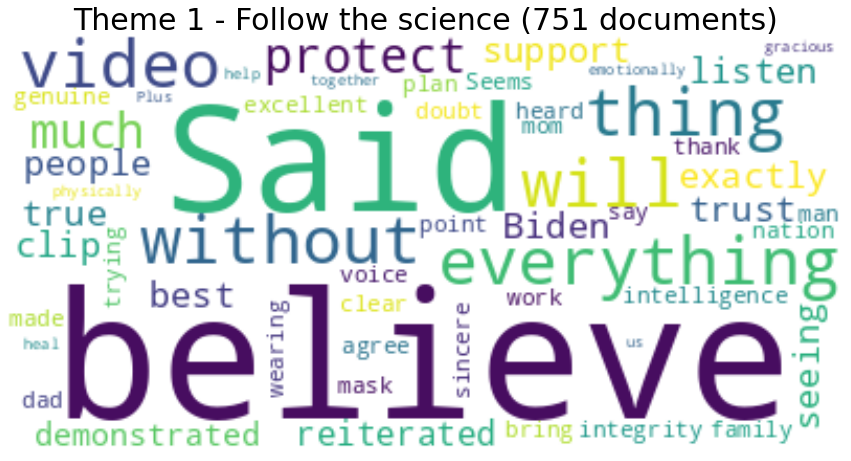

In [10]:
theme1_pos_msg = " ".join([doc for doc_id, doc in highest_performing_docs.items() if "Theme #1" in doc_id])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(theme1_pos_msg)
plt.figure(figsize=[15, 8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Theme 1 - Follow the science (751 documents)", fontsize=30, pad=2)
plt.show()

**Related theme (True counts):**
* *Believes Science And Experts*: 759

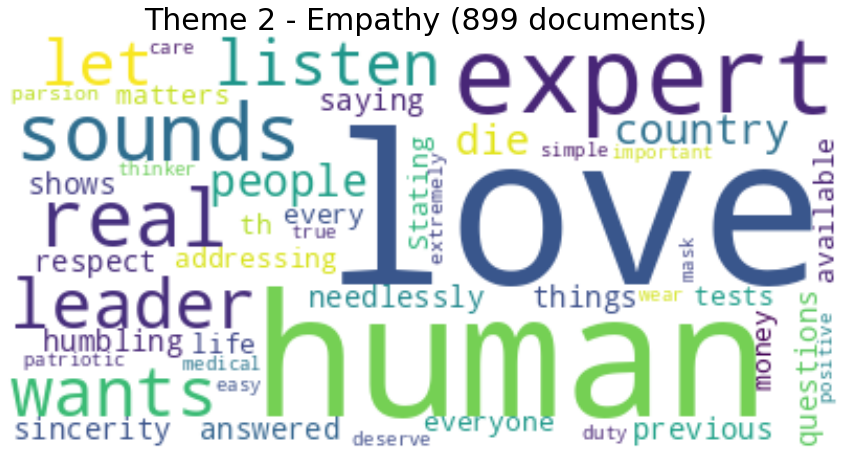

In [11]:
theme2_pos_msg = " ".join([doc for doc_id, doc in highest_performing_docs.items() if "Theme #2" in doc_id])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(theme2_pos_msg)
plt.figure(figsize=[15, 8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Theme 2 - Empathy (899 documents)", fontsize=30, pad=2)
plt.show()

**Related theme (True counts):**
* *Cares about all Americans:* 478

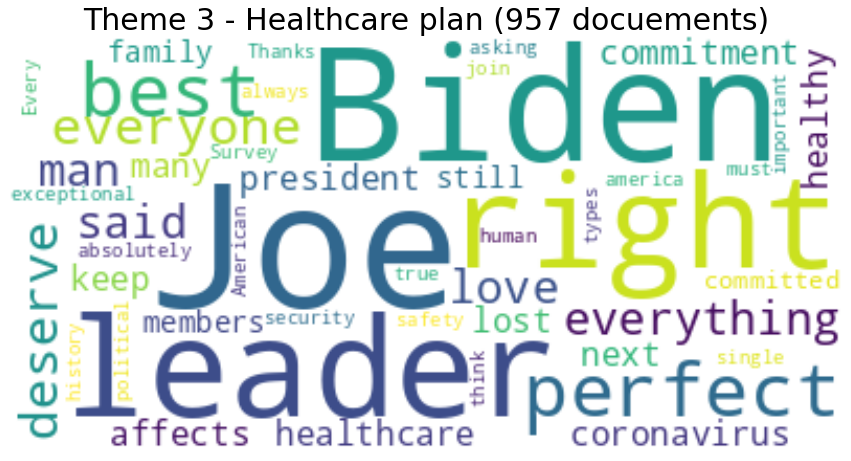

In [12]:
theme3_pos_msg = " ".join([doc for doc_id, doc in highest_performing_docs.items() if "Theme #3" in doc_id])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(theme3_pos_msg)
plt.figure(figsize=[15, 8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Theme 3 - Healthcare plan (957 docuements)", fontsize=30, pad=2)
plt.show()

**Related theme (True counts):**
* *Has a plan to protect Americans from COVID:* 725

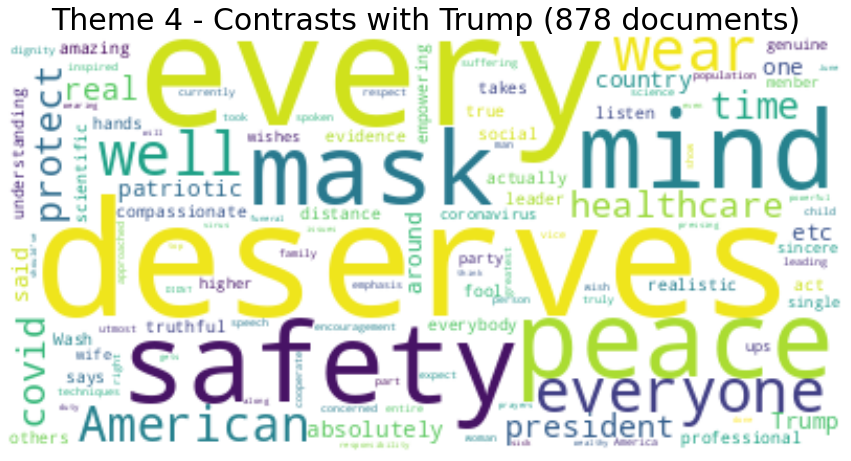

In [13]:
theme4_pos_msg = " ".join([doc for doc_id, doc in highest_performing_docs.items() if "Theme #4" in doc_id])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(theme4_pos_msg)
plt.figure(figsize=[15, 8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Theme 4 - Contrasts with Trump (878 documents)", fontsize=30, pad=2)
plt.show()

**Related theme (True counts):**
* *Cares about all Americans: 478*